## Load Data and Feature Extraction

In [27]:
# load data
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import mne
import mne_qt_browser
from scipy.stats import skew, kurtosis

# execute ls, sort files by date created
output = subprocess.run(["ls -t ../data_named"], stdout=subprocess.PIPE, shell=True, text=True)
# show only the last 5 files, line by line
files = output.stdout.split("\n")[:-1][:5]
filename = None
i = 0
print("\n>> Select file to analyze:\n")
for file in files:
    print("  ", i, ":", file)
    i += 1
index = input("\n>> ")
if index == "":
    index = 0 # if no input, default to the most recent file
    filename = files[index]
    print("\nOK, most recent file: ", filename)
else:
    index = int(index)
    filename = files[index]
    print("\nOK, opening: ", filename)


>> Select file to analyze:

   0 : 0210_second.npz
   1 : 0210_first.npz
   2 : 0225_arjun.npz



OK, opening:  0225_arjun.npz


In [28]:
# feature extraction
import scipy.signal as signal
import scipy.stats as stats

class DataBuilder:
    def __init__(self, sfreq):
        self.sfreq = sfreq

    def load_data(self, data_path):
        # Load the .npz file
        data = np.load(data_path, allow_pickle=True)
        labels = []
        windows = []
        for key in data.files:
            label = data[key].item()['label']
            window = data[key].item()['data']
            labels.append(label)
            windows.append(window)
        # dropping the first window because it's "rest"
        # drop the last window too
        return windows[1:-1], labels[1:-1]
    
    def load_window(self, data_path, index):
        # Load the .npz file
        windows, labels = self.load_data(data_path)
        windows = self.preprocess_data(windows)
        return windows[index], labels[index]

    def preprocess_data(self, windows):
        # remove the first two columns of each window (millis and hall sensor)
        processed_windows = []
        for window in windows:
            window = np.delete(window, [0,1], axis=1)
            processed_windows.append(window)
        
        print("Printing some stats!\n====================")
        print("Number of samples:", len(processed_windows))
        print("Number of channels:", len(processed_windows[0][0]))
        print("====================\n")

        return processed_windows
    
    def create_feature_vector(self, window):
        # window has shape samples x channels
        features = []
        print("Window shape:", window.shape)
        for channel in window.T:
            # extract mean and std
            mean = np.mean(channel)
            std = np.std(channel)

            # demean and normalize
            channel = channel - np.mean(channel)
            channel = channel / np.std(channel)

            # calculate features
            kurtosis = stats.kurtosis(channel)
            skew = stats.skew(channel)
            # find peaks
            peaks, _ = signal.find_peaks(channel)
            num_peaks = len(peaks)
            # find zero crossings
            zero_crossings = np.where(np.diff(np.sign(channel)))[0]
            num_zero_crossings = len(zero_crossings)

            # IEMG
            iemg = np.sum(np.abs(channel))
            # print("IEMG:", iemg)

            # MAV
            mav = np.mean(np.abs(channel))
            # print("MAV:", mav)

            # SSI
            ssi = np.sum(np.square(channel))
            # print("SSI:", ssi)

            # RMS
            rms = np.sqrt(np.mean(np.square(channel)))
            # print("RMS:", rms)

            # VAR
            var = np.var(channel)
            # print("VAR:", var)

            # Myopulse Percentage Rate
            t_mmp = 0.1
            mmp = np.sum(np.abs(channel) > t_mmp) / len(channel)
            # print("MMP:", mmp)

            # Waveform Length
            wl = np.sum(np.abs(np.diff(channel)))
            # print("WL:", wl)

            # DAMV
            damv = np.mean(np.abs(np.diff(channel)))
            # print("DAMV:", damv)

            # M2
            m2 = np.sum(np.square(np.diff(channel)))
            # print("M2:", m2)

            # DVARV
            dvarv = np.mean(np.square(np.diff(channel)))
            # print("DVARV:", dvarv)

            # DASDV
            dasdv = np.sqrt(np.mean(dvarv))
            # print("DASDV:", dasdv)

            # WAMP
            t_wamp = 0.1
            wamp = np.sum(np.abs(np.diff(channel)) > t_wamp)
            # print("WAMP:", wamp)

            # inegerated absolute of second derivative
            iasd = np.sum(np.abs(np.diff(np.diff(channel))))

            # integrated absolute third derivative
            iatd = np.sum(np.abs(np.diff(np.diff(np.diff(channel)))))

            # integerated exponential of absolute value
            # ieav = np.sum(np.exp(np.abs(channel)))
            # print("IEAV:", ieav)

            # integerated absolute log value
            # ialv = np.sum(np.log(np.abs(channel) + 0.1))
            # print("IALV:", ialv)
            # print(np.min(channel))
            # print(np.max(channel))
            # print(np.isnan(channel).any())

            # integrated exponential
            ie = np.sum(np.exp(channel))

            features.append(kurtosis)
            features.append(skew)
            features.append(num_peaks)
            features.append(num_zero_crossings)
            # features.append(mean)
            # features.append(std)
            features.append(iemg)
            # features.append(mav)
            features.append(ssi)
            # features.append(rms)
            # features.append(var)
            features.append(mmp)
            features.append(wl)
            # features.append(damv)
            features.append(m2)
            features.append(dvarv)
            features.append(dasdv)
            features.append(wamp)
            features.append(iasd)
            features.append(iatd)
            # features.append(ieav)
            # features.append(ialv)
            features.append(ie)

        features = np.array(features)
        return features

    def create_feature_matrix(self, windows):
        # windows has shape windows x samples x channels
        feature_matrix = []
        for window in windows:
            feature_vector = self.create_feature_vector(window)
            feature_matrix.append(feature_vector)

        feature_matrix = np.array(feature_matrix)
        print("Feature matrix shape:", feature_matrix.shape)
        return feature_matrix
    
    def get_labels(self):
        return self.labels

    def build_data(self, data_path):
        # Load data
        windows, labels = self.load_data(data_path)
        print("Number of labeled samples:", len(windows))

        # Preprocess data
        windows = self.preprocess_data(windows)

        # Create feature matrix
        X = self.create_feature_matrix(windows)

        # Get labels
        y = labels

        return X, y

In [29]:
# run feature extraction
npz_file_path = f"../data_named/{filename}"

data_builder = DataBuilder(sfreq=1000)
X, y = data_builder.build_data(data_path=npz_file_path)

window_4, label_4 = data_builder.load_window(npz_file_path, 4)

print("X shape:", X.shape)
print("y shape:", len(y))

Number of labeled samples: 119
Printing some stats!
Number of samples: 119
Number of channels: 4

Window shape: (843, 4)
Window shape: (1015, 4)
Window shape: (776, 4)
Window shape: (889, 4)
Window shape: (1117, 4)
Window shape: (710, 4)
Window shape: (736, 4)
Window shape: (904, 4)
Window shape: (677, 4)
Window shape: (969, 4)
Window shape: (914, 4)
Window shape: (924, 4)
Window shape: (1045, 4)
Window shape: (1077, 4)
Window shape: (921, 4)
Window shape: (1070, 4)
Window shape: (706, 4)
Window shape: (916, 4)
Window shape: (831, 4)
Window shape: (592, 4)
Window shape: (827, 4)
Window shape: (1042, 4)
Window shape: (1125, 4)
Window shape: (1113, 4)
Window shape: (1115, 4)
Window shape: (933, 4)
Window shape: (1005, 4)
Window shape: (1186, 4)
Window shape: (848, 4)
Window shape: (946, 4)
Window shape: (921, 4)
Window shape: (767, 4)
Window shape: (1130, 4)
Window shape: (877, 4)
Window shape: (623, 4)
Window shape: (1069, 4)
Window shape: (1218, 4)
Window shape: (800, 4)
Window shape: 

/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_964/3012621795.py:54: RuntimeWarning: divide by zero encountered in divide
  channel = channel / np.std(channel)
/var/folders/js/fb9kwys10ln8jgq1bxxqg0tr0000gn/T/ipykernel_964/3012621795.py:54: RuntimeWarning: invalid value encountered in divide
  channel = channel / np.std(channel)


Printing some stats!
Number of samples: 119
Number of channels: 4

X shape: (119, 60)
y shape: 119


## Multiclass Classification

In [30]:
# split data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# drop nans in X_test
y_test = np.array(y_test)
y_test = y_test[~np.isnan(X_test).any(axis=1)]
X_test = X_test[~np.isnan(X_test).any(axis=1)]
y_train = np.array(y_train)
y_train = y_train[~np.isnan(X_train).any(axis=1)]
X_train = X_train[~np.isnan(X_train).any(axis=1)]

### Logitsic

In [31]:
from sklearn.linear_model import LogisticRegression

# fit the model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.34
                precision    recall  f1-score   support

        clench       0.67      0.44      0.53         9
          rest       0.00      0.00      0.00         7
thumb-to-index       0.43      0.23      0.30        13
thumb-to-pinky       0.40      0.67      0.50         9

      accuracy                           0.34        38
     macro avg       0.37      0.34      0.33        38
  weighted avg       0.40      0.34      0.35        38



/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# def run_inference(window, model):
#     feature_vector = data_builder.create_feature_vector(window)
#     feature_vector = np.array([feature_vector])
#     print("Feature vector shape:", feature_vector.shape)
#     prediction = model.predict(feature_vector)
#     return prediction

# prediction = run_inference(window_4, model)
# print("Prediction:", prediction)
# print("Actual:", label_4)

### QDA

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# fit the model
qda = QuadraticDiscriminantAnalysis(tol=1e-1)
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.42
                precision    recall  f1-score   support

        clench       0.30      0.33      0.32         9
          rest       0.36      0.71      0.48         7
thumb-to-index       0.58      0.54      0.56        13
thumb-to-pinky       0.50      0.11      0.18         9

      accuracy                           0.42        38
     macro avg       0.44      0.42      0.38        38
  weighted avg       0.45      0.42      0.40        38



/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### LDA

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# fit the model
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.24
                precision    recall  f1-score   support

        clench       0.24      1.00      0.39         9
          rest       0.00      0.00      0.00         7
thumb-to-index       0.00      0.00      0.00        13
thumb-to-pinky       0.00      0.00      0.00         9

      accuracy                           0.24        38
     macro avg       0.06      0.25      0.10        38
  weighted avg       0.06      0.24      0.09        38



/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


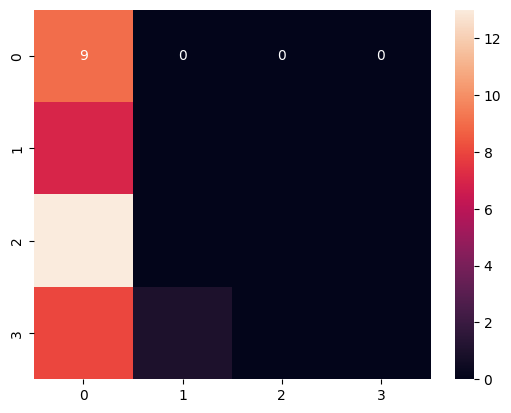

In [35]:
# confusion matrix for y_test and y_pred
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

## Binary Classification

Remap to classify only two classes of movements

In [36]:
np.array(y)

array(['thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index', 'thumb-to-pinky', 'clench', 'rest',
       'thumb-to-index',

In [37]:
# remap labels
thumb_labels = ["thumb-to-index", "thumb-to-pinky"]
y_remap = []
for label in y:
    if label in thumb_labels:
        y_remap.append("thumb")
    if label == "clench":
        y_remap.append("clench")
    if label == "rest":
        y_remap.append("rest")
y_remap = np.array(y_remap)

In [38]:
# get rid of rest
idx = (y_remap != "rest")
X_remap = X[idx]
y_remap = y_remap[idx]

In [39]:
X_remap.shape

(90, 60)

In [40]:
y_remap.shape

(90,)

In [41]:
# split the data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train_rm, X_test_rm, y_train_rm, y_test_rm = train_test_split(X_remap, y_remap, test_size=0.2, random_state=42)
# drop nans
y_test_rm = np.array(y_test_rm)
y_test_rm = y_test_rm[~np.isnan(X_test_rm).any(axis=1)]
X_test_rm = X_test_rm[~np.isnan(X_test_rm).any(axis=1)]
y_train_rm = np.array(y_train_rm)
y_train_rm = y_train_rm[~np.isnan(X_train_rm).any(axis=1)]
X_train_rm = X_train_rm[~np.isnan(X_train_rm).any(axis=1)]


### Logistic

In [42]:
# logistic
from sklearn.linear_model import LogisticRegression

# fit the model
model = LogisticRegression()
model.fit(X_train_rm, y_train_rm)
y_pred_rm = model.predict(X_test_rm)

# Evaluate the model
accuracy = accuracy_score(y_test_rm, y_pred_rm)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test_rm, y_pred_rm))

Accuracy: 0.69
              precision    recall  f1-score   support

      clench       0.56      1.00      0.71         5
       thumb       1.00      0.50      0.67         8

    accuracy                           0.69        13
   macro avg       0.78      0.75      0.69        13
weighted avg       0.83      0.69      0.68        13



/Users/bei/anaconda3/envs/ntb/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [43]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# scaling
sc = StandardScaler()
sc.fit(X_train_rm)
X_train_rm_std = sc.transform(X_train_rm)
X_test_rm_std = sc.transform(X_test_rm)

# fit the model
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_rm_std, y_train_rm)
y_pred_rm = svm.predict(X_test_rm_std)

# Evaluate the model
accuracy = accuracy_score(y_test_rm, y_pred_rm)
print(f'Accuracy: {accuracy:.2f}')

# Additional metrics
print(classification_report(y_test_rm, y_pred_rm))

Accuracy: 0.77
              precision    recall  f1-score   support

      clench       0.62      1.00      0.77         5
       thumb       1.00      0.62      0.77         8

    accuracy                           0.77        13
   macro avg       0.81      0.81      0.77        13
weighted avg       0.86      0.77      0.77        13

